# Projeto 1 - Ciência dos Dados

Nome: Venâncio Freitas de Araújo Filho

Nome: Wellington Rodrigues da Silva

## 1. Importando as Bibliotecas e fazendo um reconhecimentos das bases de dados.

### 1.1 Importante e baixando Bibliotecas que serão testadas ou utilizadas no projeto: 

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import unicodedata
import nltk
import re 

from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\venan\OneDrive - Insper - Institudo de Ensino e Pesquisa\DATA - Projects\Projetos - Machine Learning e Exploratória\Classificador-de-Mensagens---Amazon


#### Tratamento dos dados para treinamentos do boot: 

Carregando a base de dados de  com os tweets classificados manualmente:

In [6]:
train = pd.read_excel('dados_treino.xlsx')
train

,Mensagem,Target
0,Muito erros grosseiros de tradução. O material...,Editora
1,"Primeiramente meu pedido nem veio,Mas me reemb...",Amazon
2,"Livro com um monte de clichês, mas com pouco c...",Editora
3,Sim.adorei o livro Vou continuar a comprar o r...,Editora
4,Não recebi o livro . Não sei o motivo. Foi fei...,Amazon
...,...,...
293,O livro foi classificado como novo no site e c...,Amazon
294,"Não gostei porquê a capa veio com um rasgo, o ...",Amazon
295,EU NEM SE QUER RECEBI O PRODUTO! Voces são mui...,Amazon
296,Não consigo entender o alto valor desses e-boo...,Amazon


#### Analisando a proporção dos valores nessa base de dados:


Nessa etapa, é relevante preocupar-se com uma distribuição semelhante entre os rótulos utilizados, para evitar discrepâncias no posterior cálculo de probabilidade, que será explicado.

In [7]:
train.Target.value_counts(True).round(3)

Autor      0.377
Editora    0.311
Amazon     0.311
Name: Target, dtype: float64

#### Tratamento dos dados da base de dados do Teste do Bot:


In [8]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Target
0,Amontoado de proposições absurdas destinadas a...,Autor
1,Quando comprei esse livro fui com uma grande e...,Autor
2,Li um terço do livro. Arrastei-me para procura...,Autor
3,"Sensacionalista, raso e cheio de distorções ma...",Autor
4,A mensagem do livro da pra entender em 1 págin...,Autor


#### Analisando a proporção dos valores 

In [9]:
test.Target.value_counts()

Autor      102
Editora     76
Amazon      33
Name: Target, dtype: int64

In [10]:
test.Target

0      Autor
1      Autor
2      Autor
3      Autor
4      Autor
       ...  
206    Autor
207    Autor
208    Autor
209    Autor
210    Autor
Name: Target, Length: 211, dtype: object

___
# Classificador Automático de Mensagens

Diante do cenário de digitalização global, é relevante para as plataformas a preocupação com a experiência dos clientes. Assim, coube ao grupo em questão, otimizar o processo de identificação de possíveis feedbacks dos clientes.Assim,projetou-se um Bot para, a partir das palavras da mensagem de feedback digitada pelo cliente na plataforma de serviço Amazon, encaminhá-la para 3 diferentes grupos, que, a partir da análise da mensagem, discutirão melhorias na experiência do cliente. Os 3 grupos são: 

- Grupo 1: Autor do Livro em questão 
- Grupo 2: Editora do Livro em questão 
- Grupo 3: Serviços prestados pela plataforma Amazon



___
# Configurações Iniciais: 

Para iniciar o projeto, notou-se que há uma grande quantidade de caracteres nas bases de dados, que dificultam que o tratamento seja feita de uma maneira, de fato, adequada , visto que, não agregam em nada à mensagem que o cliente busca transmitir na crítica. 

Assim, foram elaboradas funções que realizassem essa 'limpeza' do texto:

## 1. Funções de Limpeza do texto

### Função 1 : Retirada de pontuações das mensagens

Esse é um passo interessante, pois, as pontuações não transmitem nenhuma informação de relevância para a plataforma de serviços em questão, visto que não transmitem críticas a questões qualitativas do serviço.

In [11]:
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$'']' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

### Função 2: Extração do Radical de cada palavra

Muito relevante pois, palavras com mesma origem, que partem de sufixos diferentes, sem essa abordagem, receberiam classificações diferentes. Porém, com a função Steamming, esse tipo de erro 'simples' é evitado pelo classificador.  

In [12]:
def steamming(texto): #Recebe lista 
    stemmed_palavras = []
    stemmer = PorterStemmer()
    for palavra in texto:
        
        stemmed_palavras.append(stemmer.stem(palavra)) 
    
    return stemmed_palavras


### Função 3: Extração de 'Stopwords' do texto

Função que busca extrair palavras 'sem significado' do texto.É relevante para contextos específicos, como por exemplo, análise crítica de livros, visto que foca nas palavras que, de fato, expressam valores.

In [13]:
def stopwords2(texto): #Recebe lista 
    palavras_sem_stopwords = []
    palavras = word_tokenize(' '.join(texto), language='portuguese')

    stopwords_pt = set(stopwords.words('portuguese'))
    
    for palavra in palavras:
        if palavra not in stopwords_pt:
            palavras_sem_stopwords.append(palavra)
    
    return palavras_sem_stopwords

### Função 4: Remoção de Emojis dos textos 

Retirada de emojis do texto, já que os emojis não expressam mensagens que, de fato, possam ser traduzidas, por a sua interpretação ser muito subjetiva e, por complementar termos em muitas ocasiões. 

In [14]:
def remove_emojis(texto): #Recebe lista 
    texto = ' '.join(texto)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Símbolos e pictogramas diversos
                           u"\U0001F700-\U0001F77F"  # Símbolos alquímicos
                           u"\U0001F780-\U0001F7FF"  # Símbolos de palavras
                           u"\U0001F800-\U0001F8FF"  # Símbolos de árabes estendidos-A
                           u"\U0001F900-\U0001F9FF"  # Símbolos suplementares de árabes estendidos-B
                           u"\U0001FA00-\U0001FA6F"  # Símbolos de xadrez
                           u"\U0001FA70-\U0001FAFF"  # Símbolos suplementares de xadrez
                           u"\U0001F004-\U0001F0CF"  # Símbolos de domino
                           u"\U0001F170-\U0001F251"  # Símbolos de tai-xi
                           u"\U0001F300-\U0001F5FF"  # Símbolos e pictogramas diversos
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F680-\U0001F6FF"  # Transporte e mapas
                           u"\U0001F700-\U0001F77F"  # Símbolos alquímicos
                           u"\U0001F780-\U0001F7FF"  # Símbolos de palavras
                           u"\U0001F800-\U0001F8FF"  # Símbolos de árabes estendidos-A
                           u"\U0001FA00-\U0001FA6F"  # Símbolos de xadrez
                           u"\U0001FA70-\U0001FAFF"  # Símbolos suplementares de xadrez
                           "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', texto)
    emoji_pattern = emoji_pattern.split(' ')
    return emoji_pattern


### Função 5: Remoção de Acentuação das Palavras

Retirada de acentuação das palavras contidas no texto, ja que a maioria das palavras escritas são de maneira informação, sem acentuação e as que possuem acentuação acabam alterando o resultado obtido.


In [15]:
def remove_acentuacao(texto):
    texto_sem_acentos = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    return re.sub(r'[^a-zA-Z0-9\s]', '', texto_sem_acentos)

## 2. Funções de extração dos textos do Dataframe: 

### Função 1: Limpeza do Dataframe

Responsável por retirar as mensagens dos Dataframes, e separá-las. 

In [16]:
def extracao_texto(series): 
    texto_novo = ''
    for linha in series:
        texto_novo += linha + ' '
    return texto_novo 

### Função 2: Extração e limpeza dos textos para cada Rótulo

Otimização dos números de linhas de código utilizada para cada rótulo

In [17]:
def transforma_rotulo(dataframe , string_rotulo):
    dados_rotulo = dataframe.loc[dataframe.Target == string_rotulo , : ]
    texto_rotulo = extracao_texto(dados_rotulo.Mensagem)
    texto_rotulo = cleanup(texto_rotulo)
    texto_rotulo = texto_rotulo.lower()
    texto_rotulo = remove_acentuacao(texto_rotulo)
    texto_rotulo = texto_rotulo.split(' ')
    texto_rotulo = remove_emojis(texto_rotulo)
    #texto_rotulo = stopwords2(texto_rotulo)
    texto_rotulo = steamming(texto_rotulo)
    tabela_rotulo = pd.Series(texto_rotulo)
    return [tabela_rotulo , texto_rotulo]


# Montando um classificador Naive-Bayes

# Tratamento dos dados de cada rótulo

 - Com as configurações das funções montadas, iniciou-se a etapa do tratamento das mensagens referentes à cada rótulo,classificados manualmente. Nessa etapa, será utilizada a base de dados de treinamento, com maior tamanho em relação à base de teste. Fará o robô identificar as frequências das palavras frequentes em cada rótulo e, a partir disso, esse valor será utilizado no cálculo de probabilidade posterior.

### 1. Tratamento dos rótulos do Autor 

- Extraindo os dados e implementando as limpezas. 

In [18]:
#Montando um Texto
tabela_autor = transforma_rotulo(train , 'Autor')[0]
texto_autor = transforma_rotulo(train , 'Autor')[1]
print(tabela_autor.shape)

(6683,)


- Tabela de palavras com frequência absoluta

In [19]:
#Frequências Absolutas 
tabela_autor_abs = tabela_autor.value_counts()
tabela_autor_abs

e              317
de             256
o              237
que            223
a              202
              ... 
praticament      1
apontar          1
efetivo          1
progresso        1
sentimento       1
Length: 1816, dtype: int64

- Tabela de palavras com Frequência relativa

In [20]:
#Frequências relativas 
tabela_autor_relativa = tabela_autor.value_counts(True)
tabela_autor_relativa 

e              0.047434
de             0.038306
o              0.035463
que            0.033368
a              0.030226
                 ...   
praticament    0.000150
apontar        0.000150
efetivo        0.000150
progresso      0.000150
sentimento     0.000150
Length: 1816, dtype: float64

- Número de palavras no Dataframe

In [21]:
tabela_autor_abs.sum()

6683

### 2. Tratamentos dos dados do rótulo da Editora

- Extração dos dados da Editora

In [22]:
tabela_editora = transforma_rotulo(train , 'Editora')[0]
texto_editora = transforma_rotulo(train , 'Editora')[1]
print(tabela_editora.head())
print(tabela_editora.shape)

0        muito
1         erro
2    grosseiro
3           de
4     traducao
dtype: object
(4727,)


- Tabela de frequências absolutas das palavras 

In [23]:
#Frequência absoluta
tabela_editora_abs = tabela_editora.value_counts()
tabela_editora_abs

e            199
de           194
a            167
o            139
que          134
            ... 
avaliacao      1
reduza         1
dezena         1
resisti        1
frustada       1
Length: 1494, dtype: int64

- Tabela de Frequências relativas das palavras

In [24]:
#Frequência Relativa 
tabela_editora_relativa = tabela_editora.value_counts(True)
tabela_editora_relativa

e            0.042099
de           0.041041
a            0.035329
o            0.029406
que          0.028348
               ...   
avaliacao    0.000212
reduza       0.000212
dezena       0.000212
resisti      0.000212
frustada     0.000212
Length: 1494, dtype: float64

In [25]:
#Quantidade de palavras 
tabela_editora_abs.sum()

4727

### 3. Tratamento dos dados do Rótulo da Amazon


- Extraindo os dados 

In [26]:
tabela_amazon = transforma_rotulo(train , 'Amazon')[0]
texto_amazon = transforma_rotulo(train , 'Amazon')[1]
print(tabela_amazon.shape)

(4691,)


 - Frequências absolutas das palavras:  

In [27]:
#Frequência absoluta 
tabela_amazon_abs = tabela_amazon.value_counts()
tabela_amazon_abs

e           212
o           177
a           163
que         129
nao         108
           ... 
preciso       1
dizer         1
ola           1
copia         1
melhorar      1
Length: 1252, dtype: int64

- Frequência relativa das palavras

In [28]:
#Frequência relativa
tabela_amazon_relativa = tabela_amazon.value_counts(True)
tabela_amazon_relativa

e           0.045193
o           0.037732
a           0.034747
que         0.027499
nao         0.023023
              ...   
preciso     0.000213
dizer       0.000213
ola         0.000213
copia       0.000213
melhorar    0.000213
Length: 1252, dtype: float64

- Número de palavras

In [29]:
tabela_amazon_abs.sum()

4691

___
# Construindo o Classificador a partir dos testes



In [30]:
def lista_sem_repetição(lista_palavras_totais):
    lista_sem_repeticao = []
    for palavras in lista_palavras_totais: 
        if palavras not in lista_sem_repeticao:
            lista_sem_repeticao.append(palavras)
    return lista_sem_repeticao

In [31]:
todas_palavras = texto_editora + texto_amazon + texto_autor
lista_sem_repeticao = lista_sem_repetição(todas_palavras)
len(lista_sem_repeticao)

3274

# 1 Probabilidade de Cada Rótulo dentro do texto

In [32]:
def prob_rotulo(lista_todas_palavras , tabela_rotulos):
    probabilidade = sum(tabela_rotulos) / len(lista_todas_palavras)
    return probabilidade

In [33]:
P_Autor = prob_rotulo(todas_palavras , tabela_autor_abs)
P_Autor

0.41506738711881247

In [34]:
P_Amazon = prob_rotulo(todas_palavras , tabela_amazon_abs)
P_Amazon

0.291348363455686

In [35]:
P_Editora = prob_rotulo(todas_palavras , tabela_editora_abs)
P_Editora

0.29358424942550154

# 2. Probabilidade de aparecer em cada frase

# Função da Suavização 

In [36]:
def suavizacao(frase_linha , tabela_frequencia_abs , alpha , lista_sem_repetição , lista_palavras_rotulos):
    P_frase_dado_rótulo = 1 
    for palavra in frase_linha: 
        if palavra in lista_palavras_rotulos: 
            P_frase_dado_rótulo *= (tabela_frequencia_abs[palavra] + alpha)/ ( (len(lista_sem_repeticao) * alpha) + len(lista_palavras_rotulos))
        else: 
            P_frase_dado_rótulo *= alpha/(len(lista_palavras_rotulos) +(len(lista_sem_repeticao)* alpha))
    return P_frase_dado_rótulo

In [37]:
def vencedor (lista_probs):
    if max(lista_probs) == lista_probs[0]:
        return 'Autor'
    elif max(lista_probs) == lista_probs[1]:
        return 'Editora'
    elif max(lista_probs) == lista_probs[2]:
        return 'Amazon'
    

In [38]:
def loop_bot(dataframe , alpha , lista_rotulos , lista_sem_repeticao , lista_textos):
    
    #Extraindo as tabelas rótulos
    tabela_autor_abs = lista_rotulos[0]
    tabela_editora_abs = lista_rotulos[1]
    tabela_amazon_abs = lista_rotulos[2]
    
    #Extraindo os textos dos rótulos 
    
    texto_autor = lista_textos[0]
    texto_editora = lista_textos[1]
    texto_amazon = lista_textos[2]
    
    
    P_frase_dado_autor = 1
    P_frase_dado_editora = 1
    P_frase_dado_amazon = 1
    lista_teste = []
    lista_probs = []
    for frase in dataframe.Mensagem:
        #CleanUps
        frase = cleanup(str(frase))
        frase = frase.lower()
        frase = remove_acentuacao(frase)
        frase = frase.split(' ')
        #frase = stopwords2(frase)
        frase = remove_emojis(frase)
        frase = steamming(frase)
        
        #Probabilidade de frase dado rótulo
        P_frase_dado_autor = suavizacao(frase , tabela_autor_abs , alpha , lista_sem_repeticao , texto_autor)
        P_frase_dado_editora = suavizacao(frase , tabela_editora_abs , alpha , lista_sem_repeticao , texto_editora)    
        P_frase_dado_amazon = suavizacao(frase, tabela_amazon_abs , alpha , lista_sem_repeticao , texto_amazon) 
        
        #Probabilidade de rótulo dado frase         
        P_autor_dado_frase = P_frase_dado_autor * P_Autor
        lista_probs.append( P_autor_dado_frase)
    
        P_editora_dado_frase = P_frase_dado_editora * P_Editora
        lista_probs.append( P_editora_dado_frase)
    
        P_amazon_dado_frase =  P_frase_dado_amazon * P_Amazon
        lista_probs.append( P_amazon_dado_frase)
        
        #Definindo o resultado do Robô
        maior = vencedor(lista_probs)
        lista_teste.append(maior)
    
        #Reiniciando as variáveis 
        P_frase_dado_editora = 1
        P_frase_dado_amazon = 1
        P_frase_dado_autor = 1
    
        P_autor_dado_frase = 1
    
        P_editora_dado_frase = 1
    
        P_amazon_dado_frase =  1
        lista_probs = []
    return lista_teste 



In [39]:
lista_teste = loop_bot(test , 1 , [tabela_autor_abs , tabela_editora_abs , tabela_amazon_abs] , lista_sem_repeticao , [texto_autor , texto_editora , texto_amazon])
lista_teste

['Editora',
 'Autor',
 'Autor',
 'Editora',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Amazon',
 'Autor',
 'Editora',
 'Autor',
 'Amazon',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Editora',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Autor',
 'Autor',
 'Autor',
 'Editora',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Editora',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Autor',
 'Amazon',
 'Amazon',
 'Autor',
 'Autor',
 'Autor',
 'Autor',
 'Editora',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Amazon',
 'Editora',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Amazon',
 'Amazon',
 'Autor',
 'Amazon',
 'Amazon',
 'Editora',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Amazon',
 'Autor',
 'Autor',
 'Autor',
 'Amazon',
 'Autor',
 'Editora',
 'Editora',
 'Autor',
 'Amazon',
 'Amazon',
 'Autor',
 'Autor',
 'E

## 4. Agora, Vamos Verificar a Performance do Treino

In [40]:
def verifica_acurácia(tabela_crosstab): 
    Acurácia = 0 
    Acurácia += tabela_crosstab.Amazon[0]
    Acurácia += tabela_crosstab.Autor[1]
    Acurácia += tabela_crosstab.Editora[2]
    return Acurácia

In [41]:
test['Bot'] = lista_teste
tabela_verificação = (pd.crosstab(test.Target , test.Bot , normalize = True )*100).round(3)
print(tabela_verificação)
print(verifica_acurácia(tabela_verificação))

Bot      Amazon   Autor  Editora
Target                          
Amazon   14.692   0.474    0.474
Autor     1.422  45.024    1.896
Editora   5.213  21.327    9.479
69.195


# Verificando os verdadeiros positivos para o caso Amazon

In [42]:
P_amazon_dado_amazon = tabela_verificação.Amazon.Amazon/sum(tabela_verificação.Amazon)
P_amazon_dado_amazon

0.6888920148168988

# Verificando os casos de Falso Amazon

In [43]:
P_amazonC_dado_amazon = 1 - P_amazon_dado_amazon
P_amazonC_dado_amazon

0.31110798518310123

# Verficando verdadeiros positivos para o caso Autor


In [44]:
P_autor_dado_autor = tabela_verificação.Autor.Autor/sum(tabela_verificação.Autor)
P_autor_dado_autor

0.6737598204264871

# Verificando os casos de Falso Autor

In [45]:
P_autorC_dado_autor = 1 - P_autor_dado_autor
P_autorC_dado_autor

0.3262401795735129

# Verificação de verdadeiros positivos para o caso Editora

In [46]:
P_editora_dado_editora = tabela_verificação.Editora.Editora/sum(tabela_verificação.Editora)
P_editora_dado_editora 

0.7999831209384758

# Verificando os casos de Falso Autor

In [47]:
P_editoraC_dado_editora = 1 - P_editora_dado_editora
P_editoraC_dado_editora

0.2000168790615242

# Concluindo

Diante da criação do classificador automático, cujo principal objetivo foi a determinação do destinatário para o qual o comentário do usuário se dirigia, tal que, de primeiro momento foi-se divido a classificação em Autor, Editora e Amazon, e com isso foi obtido uma acurácia de 69,195 %. Contudo, é valido ressaltar que ao empregar a função stopwords, um dos exemplos dados no guia do projeto, cujo seu resultado é dado na transformação de palavras em seu radical, obteve-se uma acurácia de 65.877%, com isso, conclui-se que como se trata de uma base de dados onde escritas informais são corriqueiras, algo que inibisse essa visualização para o aprendizado do algoritimo tornaria mais difícil e errônea a taxa de acerto de suas classificações.

### Por que não podemos usar o próprio classificador para gerar mais amostras de treinamento?

Visto que nesse determinado contexto, foi-se obtido uma acurácia de 69,195 %; ou seja, onde cerca de 69% das classificações feita pelo classificador eram iguais às classificações feitas a mão, temos que 31% das situações em que o classificador teve problemas para determinar o destinário, poderiam ser postergadas para novas amostras criadas por ele, dessa forma teríamos um classificador cada vez menos preciso. Ademais, visto que a base de dados não é grande o suficiente para um maior "aprendizado" do algoritmo torna-se ainda menos acertivo as rotulações dadas pelo classificador. Por fim, seria necessário a rotulação manual de cada base de dados, para que dessa forma os problemas de classificações sejam arrefecidos e com uma maior base de dados possa-se obter uma maior acurácia.

### Diferentes cenários de usabilidade para o sistema de classificação Naive Bayes

Uma das usabilidades do sistema Naive Bayes é sua aplicabilidade na área da Saúde, de forma que seja possível o processamento de um grande número de dados de tal maneira que informações uteis são fornecidas para tomada de decisões. De tal modo que por meio de uma base de dados relevante sobre uma determinada doença, e os indícios característicos daquela infermidade, torna o algoritimo capaz de identificar a probabilidade diante de padrões observados e situações correlacionadas do paciente estar com aquela determinada doença, e com o diagnóstico precoce, o tratamento preventivo reduz o agravamento da situação discrita. Ademais, no setor farmacêutico é válido destacar que a usabilidade do sistema Naive Bayes é crucial identificar caractrísticas específicas em determinada porcentagem de afetados por uma determinada doença e com isso otimizar a produção de medicamentos que visem atingir um maior número de pessoas.

Outrossim, cabe destacar a usabilidade do algoritimo na previsão do tempo, visto que, diante da coleta de dados históricos e variáveis comuns para determinada situação a ser analisada ao longo de um período é possível a classificação por meio de classes, tais como: "Dia ensolarado", "Fortes Chuvas", entre outros.

Por fim, cabe o destaque do classificador no reconhecimento de imagens, onde por meio de uma base de dados, ele identifica padrões encontrados em uma determinada categoria e pode apresentar ao usuário cenários parecidos, ou classificações específicas. Trazendo para o nosso cotidiano temos o uso do Google Lens, onde é possível fazer uma pesquisa utilizando uma imagem, ou seja, o algoritimo faz o uso dos padrões identificados para que seja viável o fornecimento de informações acerca daquela forma.



### Tratamento de Mensagens

#### 1) Caso de Sarcasmo 

Durante o desenvolvimento do sistema Naive Bayes e de acordo com o artigo Naive Bayes and Text Classification, nota-se que o algoritimo leva em consideração somente a frequência das palavras e as probabilidades condicionais as quais estão relacionadas, dessa maneira, mesmo que haja uma base de dados na qual há ocorência de palavras com sarcasmo, o classificador teria dificiculdade de obter êxito na previsão de determinada classe, visto que ele não leva em conta a intenção, ênfase e intonação, fatores que caracterizam um sarcasmo.


#### 2) Caso de Dupla Negação

Levando em conta as características apresentadas pelo algoritimo, as quais foram destacadas acima, não é possível uma analise precisa por parte do classificador, visto que palavras negativas, levam a exclusão de determinado grupo, ou seja, um advérbio de negação seguido de uma classe pré determinada poderia levar o algaritimo a oferecer uma classe diferente da esperada e consequente um menor acurácia sobre a categorização.

### Sugestões de melhoria do classificador

#### 1) Metódo de utilização do N-gramas de palavras

Dado um determinado contexto no qual se deseja analisar, temos a possiblidade de fazer o uso do método de N-gramas, em que o termo "N" é o número de elementos que se deseja analisar. Ademais, o método se baseia na divisão do texto observado em sequência de palavras sejam elas de forma consecutiva ou sequencial e dessa forma a identificação de palavras-chave que leve a uma determinada torna a classificação mais fácil.

##### Implementação

###### Para implementação deste método no código, precisamos fazer a utilização da biblioteca NLTK, a qual pode ser instalada da seguinte maneira:

"pip install nltk"

###### Posteriormente, torna-se necessário a importação da biblioteca, que é feito da seguinte forma:

import nltk

from nltk.util import ngrams

###### Por fim, por meio de uma função pode-se dividir o texto em palavras e gerar a quantidade de N-gramas desejados:

Fonte : "Speech and Language Processing" de Daniel Jurafsky e James H. Martin.

#### 2) Metódo TF-IDF

Esse método é dividido em duas análises: TF, na qual é medido a frequência que a palavra aparece no nosso objeto de análise e IDF que calcula a raridade da aparição de determinado termo naquele todo. Com estas analises em mãos temos a importância relativa do termo no documento de analise e consequentemente a classificação feita pelo algoritimo é facilitada.

##### Implementação

###### Para implementação deste método no código, precisamos fazer a utilização da biblioteca NLTK, a qual pode ser instalada da seguinte maneira:

pip install scikit-learn

###### Posteriormente, torna-se necessário a importação da classe "TfidfVectorizer", que é feito da seguinte forma:

from sklearn.feature_extraction.text import TfidfVectorizer

###### Por fim, por meio da implmentação da função abaixo :

Fonte: Understanding TF-ID: A Simple Introduction - Monkey Learn

# Testando o Robô para diferentes situações 

In [48]:
dataframe_final = pd.read_excel('planilha_junta.xlsx')
lista_acurácias = []
for i in range(100):
    dataframe_dividido = train_test_split(dataframe_final , test_size =0.4 , shuffle = True)
    train_final = dataframe_dividido[0]
    test_final = dataframe_dividido[1]
    #Extração das tabelas 
    tabela_autor = transforma_rotulo(train_final , 'Autor')[0]
    texto_autor = transforma_rotulo(train_final , 'Autor')[1]
    
    tabela_editora = transforma_rotulo(train_final , 'Editora')[0]
    texto_editora = transforma_rotulo(train_final , 'Editora')[1]

    tabela_amazon = transforma_rotulo(train_final , 'Amazon')[0]
    texto_amazon = transforma_rotulo(train_final , 'Amazon')[1]

    #Extraindo as tabelas e as Palavras 
    #Tabelas Absolutas 

    tabela_autor_abs = tabela_autor.value_counts()
    tabela_editora_abs = tabela_editora.value_counts()
    tabela_amazon_abs = tabela_amazon.value_counts()
    #Tabelas Relativas 
    tabela_autor_relativa = tabela_autor.value_counts(normalize=True)
    tabela_editora_relativa = tabela_editora.value_counts(normalize=True)
    tabela_amazon_relativa = tabela_amazon.value_counts(normalize=True)

    #Todas as palavras
    todas_palavras = texto_amazon + texto_autor + texto_editora
    lista_sem_repeticao = lista_sem_repetição(todas_palavras)
    
    #Iniciando o cálculo de probabilidade 
    lista_resultados = loop_bot(test_final , 1 , [tabela_autor_abs , tabela_editora_abs , tabela_amazon_abs] , lista_sem_repeticao , [texto_autor , texto_editora , texto_amazon] ) 
    #1.Probabilidade de cada rótulo 
    P_Autor = prob_rotulo(todas_palavras, tabela_autor_abs)
    P_Editora = prob_rotulo(todas_palavras , tabela_editora_abs)
    P_Amazon = prob_rotulo(todas_palavras,  tabela_amazon_abs)
    
    #Montando a lista de resultados  
    
    #Montando crosstab 
    test_final['Bot'] = lista_resultados 
    tabela_resultados = (pd.crosstab(test_final.Target , test_final.Bot , normalize=True) * 100).round(3)
    acurácia = verifica_acurácia(tabela_resultados)
    lista_acurácias.append(acurácia)
    acurácia = 0 
    
len(lista_acurácias)

100

In [49]:
resultados_boot = pd.DataFrame(lista_acurácias).round(3)
resultados_boot_desempenho = resultados_boot.describe()
resultados_boot_desempenho

,0
count,100.000000
mean,67.815080
std,2.773062
min,60.302000
25%,66.000000
50%,67.749500
75%,69.468500
max,75.125000


Text(0, 0.5, 'Frequência dos valores')

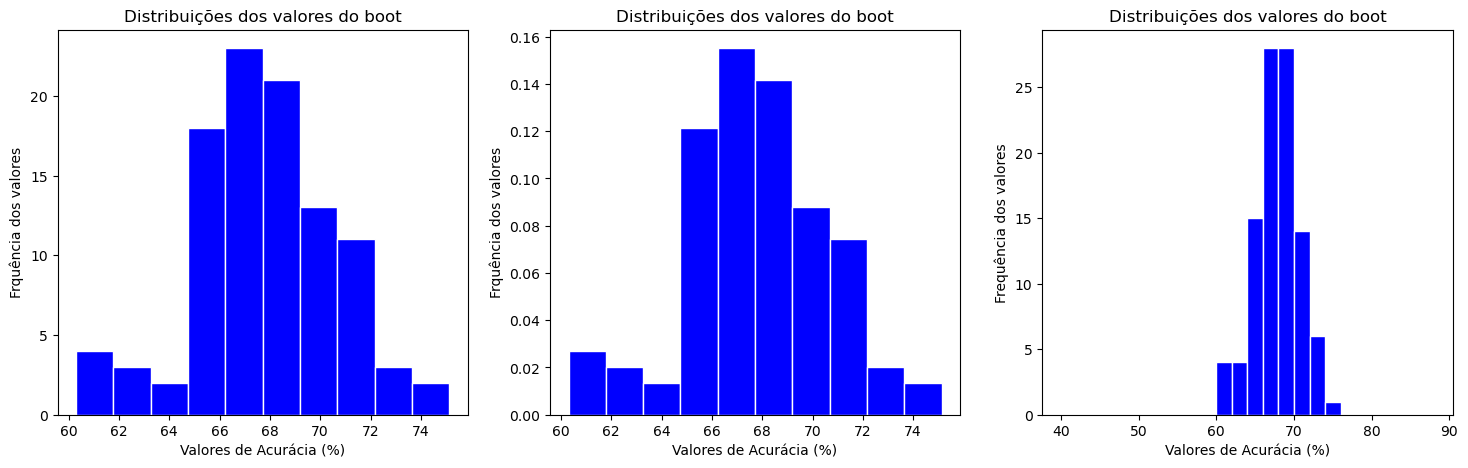

In [50]:
faixas = range(40 , 90 , 2)
plt.figure(figsize=(18,5))


plt.subplot(131)
plt.hist(resultados_boot , edgecolor='white' , color='Blue')
plt.title('Distribuições dos valores do boot')
plt.xlabel('Valores de Acurácia (%)')
plt.ylabel('Frquência dos valores')

plt.subplot(132)
plt.hist(resultados_boot , edgecolor='white' , density=True , color='Blue')
plt.title('Distribuições dos valores do boot')
plt.xlabel('Valores de Acurácia (%)')
plt.ylabel('Frquência dos valores')

plt.subplot(133)
plt.hist(resultados_boot , edgecolor='white' ,  bins=faixas , color='Blue')
plt.title('Distribuições dos valores do boot')
plt.xlabel('Valores de Acurácia (%)')
plt.ylabel('Frequência dos valores')


___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**